# Kuramoto-Sivashinsky Equation Energy-Preserving Operator Inference

ATTENTION: You will need at least 90GB of memory to run this notebook

In [1]:
using FFTW
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using ProgressMeter
using SparseArrays
using Statistics
using StatsBase

include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# Settings for the KS equation
KSE = KS(
    [0.0, 35.0], [0.0, 150.0], [1.0, 1.0],
    512, 0.001, 1, "ep"
)

# WARNING:DO YOU WANT TO SAVE DATA?
save_data = true

# Create file name to save data
datafile = "data/kse_data2.jld2"
opfile = "data/kse_operators2.jld2"
resultfile = "data/kse_results2.jld2"

# Settings for Operator Inference
KSE_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
KSE_vars = LnL.vars(
    N=1,
)
KSE_data = LnL.data(
    Δt=KSE.Δt,
    DS=100,
)
KSE_optim = LnL.opt_settings(
    verbose=true,
    initial_guess=false,
    max_iter=1000,
    reproject=false,
    SIGE=false,
    with_bnds=true,
)

options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
)

# Downsampling rate
DS = KSE_data.DS

# Down-sampled dimension of the time data
Tdim_ds = size(1:DS:KSE.Tdim, 1)  # downsampled time dimension

# Number of random test inputs
num_test_ic = 50

;


## Generate Training Data

We use the initial condition of 

$$
\begin{gather*}
    u(x,0) = a\cos\left( \frac{2\pi x}{L} \right) + b\cos\left( \frac{4\pi x}{L} \right)
\end{gather*}
$$

where $a$ and $b$ are parameters that vary

In [2]:
# Parameters of the initial condition
ic_a = [0.9, 1.0, 1.1, 1.2]
ic_b = [0.1, 0.2, 0.3, 0.4]

ic_a_out = [-1.0, 3.0]
ic_b_out = [-0.1, 0.5]
num_ic_params = Int(length(ic_a) * length(ic_b))

L = KSE.Omega[2] - KSE.Omega[1]  # length of the domain

# Parameterized function for the initial condition
u0 = (a,b) -> a * cos.((2*π*KSE.x)/L) .+ b * cos.((4*π*KSE.x)/L)  # initial condition
;  

In [3]:
# Store values
Xtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training state data 
Rtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training derivative data
Xtr_all = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_ic_params)  # all training data
IC_train = Vector{Vector{Float64}}(undef, num_ic_params)  # all initial conditions 
Vr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # POD basis
Σr = Vector{Vector{Float64}}(undef, KSE.Pdim)  # singular values 
op_fom_tr = Vector{LnL.operators}(undef, KSE.Pdim)  # FOM operators 

@info "Generate the FOM system matrices and training data."
@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A, F = KSE.model_FD(KSE, μ)
    op_fom_tr[i] = LnL.operators(A=A, F=F)

    # Store the training data 
    Xall = Vector{Matrix{Float64}}(undef, num_ic_params)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ic_params)
    
    # Generate the data for all combinations of the initial condition parameters
    # ct = 1  # set/reset counter
    ic_combos = collect(Iterators.product(ic_a, ic_b))
    prog = Progress(length(ic_combos))
    Threads.@threads for (j, ic) in collect(enumerate(ic_combos))
    # for a in ic_a, b in ic_b
        a, b = ic
        if i == 1
            IC_train[j] = u0(a, b)
        end

        # A_FFT, F_FFT = KSE.model_FFT_ew(KSE, μ)
        # states, _ = KSE.integrate_FFT_ew(A_FFT, F_FFT, KSE.t, IC_train[ct])

        states = KSE.integrate_FD(A, F, KSE.t, IC_train[j])
        Xtr_all[i,j] = states
        
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / KSE.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data

        # ct += 1  # increment counter
        next!(prog)
    end
    # Combine all initial condition data to form on big training data matrix
    Xtr[i] = reduce(hcat, Xall) 
    Rtr[i] = reduce(hcat, Xdotall)
    
    # Compute the POD basis from the training data
    tmp = svd(Xtr[i])
    Vr[i] = tmp.U
    Σr[i] = tmp.S
end


┌ Info: Generate the FOM system matrices and training data.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:10


Progress:  12%|██████                                   |  ETA: 2:16:37

Progress:  25%|███████████                              |  ETA: 0:58:47

Progress:  31%|█████████████                            |  ETA: 0:43:08

Progress:  38%|████████████████                         |  ETA: 0:32:42

Progress:  44%|██████████████████                       |  ETA: 0:25:13

Progress:  50%|█████████████████████                    |  ETA: 0:19:43

Progress: 100%|█████████████████████████████████████████| Time: 0:26:48


### Check Energy-Levels from SVD and Decide Reduced Orders

In [4]:
nice_orders_all = Vector{Vector{Int}}(undef, KSE.Pdim)
energy_level_all = Vector{Vector{Float64}}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    nice_orders_all[i], energy_level_all[i] = LnL.choose_ro(Σr[i]; en_low=-12)
end
nice_orders = Int.(round.(mean(nice_orders_all)))
energy_level = mean(energy_level_all)
;

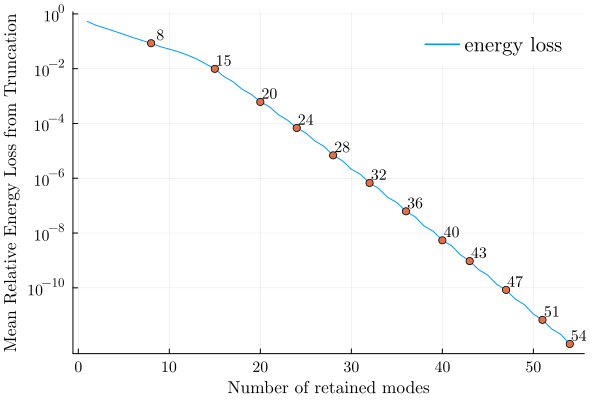

In [5]:
plot(energy_level[1:nice_orders[end]], yaxis=:log10, label="energy loss", fontfamily="Computer Modern",
    ylabel="Mean Relative Energy Loss from Truncation", xlabel="Number of retained modes", legend=:topright, majorgrid=true, grid=true)
plot!(nice_orders, energy_level[nice_orders], seriestype=:scatter, label=nothing)
for i in 1:length(nice_orders)
    annotate!([(nice_orders[i]+1.0, energy_level[nice_orders[i]], text(nice_orders[i], :bottom, 10, "Computer Modern"))])
end
yticks!(10.0 .^ (0:-2:-10))
plot!(fg_legend=:false)
plot!(guidefontsize=11, tickfontsize=10,  legendfontsize=13, right_margin=2mm)

**Based on the energy levels we select an appropriate reduced-order**

In [6]:
# Minimum and maximum dimensions
ro = nice_orders[2:8]
;

## Generate Test Data (Inside Training Region)

Generate random initial condition parameters from the training region for $\mu \in M$.

In [ ]:
# Store values
Xtest_in = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_test_ic)  # all training data 
IC_test_in = Vector{Vector{Float64}}(undef, num_test_ic)  # all initial conditions

@info "Generate test data for parameters within the training region."

# Generate 10 random initial condition parameters
ic_a_rand_in = (maximum(ic_a) - minimum(ic_a)) .* rand(num_test_ic) .+ minimum(ic_a)
ic_b_rand_in = (maximum(ic_b) - minimum(ic_b)) .* rand(num_test_ic) .+ minimum(ic_b)

@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A = op_fom_tr[i].A
    F = op_fom_tr[i].F

    # Generate the data for all combinations of the initial condition parameters
    for j in 1:num_test_ic  
        a = ic_a_rand_in[j]
        b = ic_b_rand_in[j]

        if i == 1
            IC_test_in[j] = u0(a, b)
        end
        Xtest_in[i,j] = KSE.integrate_FD(A, F, KSE.t, IC_test_in[j])
    end
end

## Generate Test Data (Outside Training Region)

Generate random initial condition parameters outside of the training region for $\mu \in M$.

In [ ]:
# Store values
Xtest_out = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_test_ic)  # all training data 
IC_test_out = Vector{Vector{Float64}}(undef, num_test_ic)  # all initial conditions

@info "Generate test data for parameters outside the training region."

# Generate 10 random initial condition parameters outside the training region
ϵ=1e-2
half_num_test_ic = Int(num_test_ic/2)
ic_a_rand_out = ((minimum(ic_a) - ϵ) - ic_a_out[1]) .* rand(half_num_test_ic) .+ ic_a_out[1]
append!(ic_a_rand_out, (ic_a_out[2] - (maximum(ic_a) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_a) + ϵ))
ic_b_rand_out = ((minimum(ic_b) - ϵ) - ic_b_out[1]) .* rand(half_num_test_ic) .+ ic_b_out[1]
append!(ic_b_rand_out, (ic_b_out[2] - (maximum(ic_b) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_b) + ϵ))

@showprogress for i in eachindex(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A = op_fom_tr[i].A
    F = op_fom_tr[i].F

    # Generate the data for all combinations of the initial condition parameters
    for j in 1:num_test_ic
        a = ic_a_rand_out[j]
        b = ic_b_rand_out[j]

        if i == 1
            IC_test_out[j] = u0(a, b)
        end
        Xtest_out[i,j] = KSE.integrate_FD(A, F, KSE.t, IC_test_out[j])
    end
end

### Save data

In [11]:
if save_data
    save(
        datafile,
        Dict("Xtr" => Xtr, "Rtr" => Rtr, "Vr" => Vr, 
            "op_fom_tr" => op_fom_tr, 
            "Xtr_all" => Xtr_all, "IC_train" => IC_train,
            "ro" => ro
        )
    )
end

## Obtain Operators using Least-Squares (Vanilla) Operator Inference

In [ ]:
Xtr = DATA["Xtr"]
Rtr = DATA["Rtr"]
ro = DATA["ro"]
Vr = DATA["Vr"]
op_fom_tr = DATA["op_fom_tr"]

In [7]:
DATA = nothing

In [8]:
GC.gc()

In [7]:
@info "Compute the Least Squares solution."
options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    # with_tol=true,
    # pinv_tol=1e-4,
    λ=LnL.λtik(       # regularization parameter
        lin=0,
        quad=0,
    ),         
)

# Store values
op_LS = Array{LnL.operators}(undef, KSE.Pdim)

@showprogress for i in eachindex(KSE.μs)
    op_LS[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
end

┌ Info: Compute the Least Squares solution.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


## Compute intrusive operators

In [9]:
@info "Compute the intrusive model"

# Store values
op_int = Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(op_fom_tr[i], Vr[i][:, 1:ro[end]], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:9


## Compute EPHEC-OpInf operators

In [9]:
@info "Compute the EPHEC model"

options = LnL.EPHEC_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    A_bnds=(-1000.0, 1000.0),
    ForH_bnds=(-100.0, 100.0),
)
op_ephec =  Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_ephec[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the EPHEC model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


## Compute EPSIC-Opinf operators

In [11]:
@info "Compute the EPSIC OpInf."

options = LnL.EPSIC_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    ϵ=1e-3,
    A_bnds=(-1000.0, 1000.0),
    ForH_bnds=(-100.0, 100.0),
)
op_epsic = Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_epsic[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the EPSIC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:215
┌ Info: Set objective
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:314


┌ Info: Add constraints
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:341


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:376
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:378


This is Ipopt version 3.14.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...: 81972000
Number of nonzeros in inequality constraint Jacobian.:    11132
Number of nonzeros in Lagrangian Hessian.............:   297000

Total number of variables............................:   303050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     6050
                     variables with only upper bounds:        0
Total number of equality constraints.................:   297000
Total number of inequality constraints...............:     4048
        inequality constraints with only lower bounds:     2024
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     2024

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.48e+01 2.56e-12  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Soft Inequality Constraint
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 22
│ solve time           = 1105.555999994278
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 0.034582799613547106
│ objective_value      = 0.017296532243462354
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:380
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:400
┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:16


## Compute EPP-OpInf operators

In [12]:
@info "Compute the EPUC OpInf."

options = LnL.EPP_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    α=1e6,
    A_bnds=(-1000.0, 1000.0),
    ForH_bnds=(-100.0, 100.0),
)
op_epp =  Array{LnL.operators}(undef, KSE.Pdim)

for i in eachindex(KSE.μs)
    op_epp[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vr[i][:, 1:ro[end]], Vr[i][:, 1:ro[end]]' * Rtr[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

┌ Info: Compute the EPUC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:428
┌ Info: Set penalty
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:528
┌ Info: Set objective
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:542


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:575
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:577


This is Ipopt version 3.14.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...: 81972000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   307648

Total number of variables............................:   303050
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     6050
                     variables with only upper bounds:        0
Total number of equality constraints.................:   297000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.48e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ EP Weight            = 1.0e6
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 22
│ solve time           = 515.2860000133514
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 0.046656038302047856
│ objective_value      = 0.02332802419186919
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:579
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:600
┌ Info: Loop 1 out of 1 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:16


### Save the operators

In [13]:
if save_data
    save(
        opfile,
        Dict("op_LS" => op_LS, "op_int" => op_int, "op_ephec" => op_ephec, 
            "op_epsic" => op_epsic, "op_epp" => op_epp)
    )
end

## Analyze Training Results

### Load the data

In [2]:
DATA = load(datafile);
OPS = load(opfile);

In [3]:
RES = load(resultfile)
RES = Dict{String, Any}(RES); # convert type to avoid errors

In [15]:
# Setup the results
RES = Dict{String, Any}()
RES["train_proj_err"] = Array{Float64}(undef, length(ro), KSE.Pdim) 
RES["train_state_err"] = Dict(
    :int => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp => Array{Float64}(undef, length(ro), KSE.Pdim),
)
RES["train_CR"] = Dict(
    :int => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp => Array{Float64}(undef, length(ro), KSE.Pdim),
    :fom => Array{Float64}(undef, KSE.Pdim)
)
RES["train_AC"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
RES["train_LE"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Array{Float64}}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
RES["train_DKY"] = Dict(
    :int   => Array{Float64}(undef, length(ro), KSE.Pdim),
    :LS    => Array{Float64}(undef, length(ro), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epsic => Array{Float64}(undef, length(ro), KSE.Pdim),
    :epp   => Array{Float64}(undef, length(ro), KSE.Pdim),
    :fom   => Array{Float64}(undef, KSE.Pdim)
)
;

In [16]:
function analyze_proj_err(model, X_all, Vr_all, IC, ro)
    num_ic_params = length(IC)
    PE_all = Array{Float64}(undef, length(ro), model.Pdim) 
    PE = Array{Float64}(undef, num_ic_params)  
    
    for i in eachindex(model.μs)
        prog = Progress(length(ro))
        for (j,r) in enumerate(ro)
            Vr = Vr_all[i][:, 1:r]
            Threads.@threads for (ct, ic) in collect(enumerate(IC))
                PE[ct] = LnL.compProjError(X_all[i,ct], Vr)
            end
            PE_all[j, i] = mean(PE)
        next!(prog)
        end
    end
    return PE_all
end

analyze_proj_err (generic function with 1 method)

In [17]:
function analyze_rse(op, model, X_all, Vr_all, IC, ro, DS, integrator)
    num_ic_params = length(IC)
    # Relative state error
    RSE_all = Array{Float64}(undef, length(ro), model.Pdim)
    RSE = Array{Float64}(undef, num_ic_params)

    for i in eachindex(model.μs)
        prog = Progress(length(ro))
        for (j,r) in enumerate(ro)
            Vr = Vr_all[i][:, 1:r]
            Threads.@threads for (ct, ic) in collect(enumerate(IC))
                Fextract = LnL.extractF(op[i].F, r)
                X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * ic)
                RSE[ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], X[:, 1:DS:end], Vr)
            end
            RSE_all[j, i] = mean(RSE)
            next!(prog)
        end
    end
    return RSE_all
end

analyze_rse (generic function with 1 method)

In [18]:
function analyze_cr(op, ForH, model, IC, ro)
    num_ic_params = length(IC)
    CR_all = Array{Float64}(undef, length(ro), model.Pdim)
    CR = Vector{Float64}(undef, num_ic_params)

    for i in eachindex(model.μs)
        for (j,r) in collect(enumerate(ro))
            for (ct, ic) in enumerate(IC)
                Fextract = LnL.extractF(op[i].F, r)
                CR[ct] =  LnL.constraintResidual(Fextract, r, ForH; with_mmt=false)
            end
            CR_all[j, i] = mean(CR)
        end
    end
    return CR_all
end

analyze_cr (generic function with 1 method)

In [19]:
function fom_CR(op, ForH, model)
    CR = Array{Float64}(undef, model.Pdim)

    for i in 1:length(model.μs)
        F_full = op[i].F
        CR[i] = LnL.constraintResidual(F_full, size(F_full, 1), ForH; with_mmt=false)
    end
    return CR
end

fom_CR (generic function with 1 method)

In [20]:
# Compute CR of full order model
RES["train_CR"][:fom] = fom_CR(DATA["op_fom_tr"], "F", KSE)

1-element Vector{Float64}:
 0.0

### __old__

In [ ]:
function EP_analyze(Data, model, integrator, options, X_all, IC; rmin=1, rmax=10, ro=nothing)

    # Projection error
    if isnothing(ro)
        ro_dim = rmax - (rmin - 1)
    else
        ro_dim = length(ro)
    end

    PE_all = Array{Float64}(undef, ro_dim, model.Pdim) 
    # Relative state error
    SE_all = Dict(
        :int => Array{Float64}(undef, ro_dim, model.Pdim),
        :LS => Array{Float64}(undef, ro_dim, model.Pdim),
        :ephec => Array{Float64}(undef, ro_dim, model.Pdim),
        :epsic => Array{Float64}(undef, ro_dim, model.Pdim),
        :epp => Array{Float64}(undef, ro_dim, model.Pdim),
    )
    # Energy 
    EN_all = Dict(
        :int => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :LS => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :ephec => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epsic => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epp => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :fom => Array{VecOrMat{Float64}}(undef, model.Pdim)
    )
    # Constraint Residual
    CR_all = Dict(
        :int => Array{Float64}(undef, ro_dim, model.Pdim),
        :LS => Array{Float64}(undef, ro_dim, model.Pdim),
        :ephec => Array{Float64}(undef, ro_dim, model.Pdim),
        :epsic => Array{Float64}(undef, ro_dim, model.Pdim),
        :epp => Array{Float64}(undef, ro_dim, model.Pdim),
        :fom => Array{Float64}(undef, model.Pdim)
    )
    # Momentum
    MMT_all = Dict(
        :int => Array{Float64}(undef, ro_dim, model.Pdim),
        :LS => Array{Float64}(undef, ro_dim, model.Pdim),
        :ephec => Array{Float64}(undef, ro_dim, model.Pdim),
        :epsic => Array{Float64}(undef, ro_dim, model.Pdim),
        :epp => Array{Float64}(undef, ro_dim, model.Pdim),
        :fom => Array{Float64}(undef, model.Pdim)
    )
    # Constraint Violation
    CV_all = Dict(
        :int => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :LS => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :ephec => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epsic => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :epp => Array{VecOrMat{Float64}}(undef, ro_dim, model.Pdim),
        :fom => Array{VecOrMat{Float64}}(undef, model.Pdim)
    )

    # Load values
    op_LS = Data["op_LS"]
    op_int = Data["op_int"]
    # op_ephec = Data["op_ephec"]
    # op_epsic = Data["op_epsic"]
    # op_epp = Data["op_epp"]
    Vrmax = Data["Vr"]

    num_ic_params = length(IC)

    @info "Analyze the operators with training data..."
    @showprogress for i in 1:length(model.μs)

        # Energy, constraint residual, and constraint violation of the FOM
        EN_all[:fom][i] = norm.(eachcol(X_all[i]), 2)
        F_full = Data["op_fom_tr"][i].F
        CR_all[:fom][i], MMT_all[:fom][i] = LnL.constraintResidual(F_full, size(F_full, 1), options.optim.which_quad_term)
        CV_all[:fom][i] = LnL.constraintViolation(X_all[i], F_full, options.optim.which_quad_term)

        if isnothing(ro)
            ro = rmin:rmax
        end
        
        for (j,r) in enumerate(ro)
            Vr = Vrmax[i][:, 1:r]

            # Temporary data storage
            PE = Array{Float64}(undef, num_ic_params)  # projection error
            SE = Dict(
                :int => Array{Float64}(undef, num_ic_params),
                :LS => Array{Float64}(undef, num_ic_params),
                :ephec => Array{Float64}(undef, num_ic_params),
                :epsic => Array{Float64}(undef, num_ic_params),
                :epp => Array{Float64}(undef, num_ic_params),
            )
            En = Dict(
                :int => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :LS => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :ephec => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epsic => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epp => Matrix{Float64}(undef, num_ic_params, model.Tdim),
            )
            CR = Dict(
                :int => Vector{Float64}(undef, num_ic_params),
                :LS => Vector{Float64}(undef, num_ic_params),
                :ephec => Vector{Float64}(undef, num_ic_params),
                :epsic => Vector{Float64}(undef, num_ic_params),
                :epp => Vector{Float64}(undef, num_ic_params),
            )
            mmt = Dict(
                :int => Vector{Float64}(undef, num_ic_params),
                :LS => Vector{Float64}(undef, num_ic_params),
                :ephec => Vector{Float64}(undef, num_ic_params),
                :epsic => Vector{Float64}(undef, num_ic_params),
                :epp => Vector{Float64}(undef, num_ic_params),
            )
            CV = Dict(
                :int => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :LS => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :ephec => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epsic => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epp => Matrix{Float64}(undef, num_ic_params, model.Tdim),
            )

            for (ct, ic) in enumerate(IC)

                # Integrate the LS operator inference model
                Finf_extract_LS = LnL.extractF(op_LS[i].F, r)
                Xinf_LS = integrator(op_LS[i].A[1:r, 1:r], Finf_extract_LS, KSE.t, Vr' * ic)

                # Integrate the intrusive model
                Fint_extract = LnL.extractF(op_int[i].F, r)
                Xint = integrator(op_int[i].A[1:r, 1:r], Fint_extract, KSE.t, Vr' * ic)
                
                # if options.optim.SIGE
                #     # Integrate the energy-preserving hard equality constraint operator inference model
                #     Finf_extract_ephec = op_ephec[i,j].F
                #     Xinf_ephec = integrator(op_ephec[i,j].A, op_ephec[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_ephec = LnL.extractF(op_ephec[i,rmax].F, r)
                #     # Xinf_ephec = integrator(op_ephec[i,rmax].A[1:r, 1:r], Finf_extract_ephec, KSE.t, Vr' * ic)
                    
                #     # Integrate the energy-preserving soft inequality constraint operator inference model
                #     Finf_extract_epsic = op_epsic[i,j].F
                #     Xinf_epsic = integrator(op_epsic[i,j].A, op_epsic[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_epsic = LnL.extractF(op_epsic[i,rmax].F, r)
                #     # Xinf_epsic = integrator(op_epsic[i,rmax].A[1:r, 1:r], Finf_extract_epsic, KSE.t, Vr' * ic)

                #     # Integrate the energy-preserving unconstrained operator inference model
                #     Finf_extract_epp = op_epp[i,j].F
                #     Xinf_epp = integrator(op_epp[i,j].A, op_epp[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_epuc = LnL.extractF(op_epuc[i,rmax].F, r)
                #     # Xinf_epuc = integrator(op_epuc[i,rmax].A[1:r, 1:r], Finf_extract_epuc, KSE.t, Vr' * ic)
                # else
                #     # Integrate the energy-preserving hard equality constraint operator inference model
                #     Finf_extract_ephec = LnL.extractF(op_ephec[i].F, r)
                #     Xinf_ephec = integrator(op_ephec[i].A[1:r, 1:r], Finf_extract_ephec, KSE.t, Vr' * ic)
                    
                #     # Integrate the energy-preserving soft inequality constraint operator inference model
                #     Finf_extract_epsic = LnL.extractF(op_epsic[i].F, r)
                #     Xinf_epsic = integrator(op_epsic[i].A[1:r, 1:r], Finf_extract_epsic, KSE.t, Vr' * ic)

                #     # Integrate the energy-preserving unconstrained operator inference model
                #     Finf_extract_epp = LnL.extractF(op_epp[i].F, r)
                #     Xinf_epp = integrator(op_epp[i].A[1:r, 1:r], Finf_extract_epp, KSE.t, Vr' * ic)
                # end

                # Compute the projection error
                PE[ct] = LnL.compProjError(X_all[i,ct], Vr)

                # Compute the relative state error
                SE[:LS][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_LS[:, 1:DS:end], Vr)
                SE[:int][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xint[:, 1:DS:end], Vr)
                # SE[:ephec][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_ephec[:, 1:DS:end], Vr)
                # SE[:epsic][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_epsic[:, 1:DS:end], Vr)
                # SE[:epp][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_epp[:, 1:DS:end], Vr)

                # Compute the energy
                En[:LS][ct, :] .= norm.(eachcol(Vr * Xinf_LS), 2)
                En[:int][ct, :] .= norm.(eachcol(Vr * Xint), 2)
                # En[:ephec][ct, :] .= norm.(eachcol(Vr * Xinf_ephec), 2)
                # En[:epsic][ct, :] .= norm.(eachcol(Vr * Xinf_epsic), 2)
                # En[:epp][ct, :] .= norm.(eachcol(Vr * Xinf_epp), 2)

                # Compute the constraint residual and momentum
                CR[:LS][ct], mmt[:LS][ct] =  LnL.constraintResidual(Finf_extract_LS, r, options.optim.which_quad_term)
                CR[:int][ct], mmt[:int][ct] = LnL.constraintResidual(Fint_extract, r, options.optim.which_quad_term)
                # CR[:ephec][ct], mmt[:ephec][ct] = LnL.constraintResidual(Finf_extract_ephec, r, options.optim.which_quad_term)
                # CR[:epsic][ct], mmt[:epsic][ct] = LnL.constraintResidual(Finf_extract_epsic, r, options.optim.which_quad_term)
                # CR[:epp][ct], mmt[:epp][ct] = LnL.constraintResidual(Finf_extract_epp, r, options.optim.which_quad_term)

                # Compute the constraint violation
                CV[:LS][ct, :] .= LnL.constraintViolation(Xinf_LS, Finf_extract_LS, options.optim.which_quad_term)
                CV[:int][ct, :] .= LnL.constraintViolation(Xint, Fint_extract, options.optim.which_quad_term)
                # CV[:ephec][ct, :] .= LnL.constraintViolation(Xinf_ephec, Finf_extract_ephec, options.optim.which_quad_term)
                # CV[:epsic][ct, :] .= LnL.constraintViolation(Xinf_epsic, Finf_extract_epsic, options.optim.which_quad_term)
                # CV[:epp][ct, :] .= LnL.constraintViolation(Xinf_epp, Finf_extract_epp, options.optim.which_quad_term)
            end

            # Compute errors
            PE_all[j, i] = mean(PE)
            SE_all[:LS][j, i] = mean(SE[:LS])
            SE_all[:int][j, i] = mean(SE[:int])
            # SE_all[:ephec][j, i] = mean(SE[:ephec])
            # SE_all[:epsic][j, i] = mean(SE[:epsic])
            # SE_all[:epp][j, i] = mean(SE[:epp])
            
            # Compute energy 
            EN_all[:LS][j, i] = mean(En[:LS], dims=1)
            EN_all[:int][j, i] = mean(En[:int], dims=1)
            # EN_all[:ephec][j, i] = mean(En[:ephec], dims=1)
            # EN_all[:epsic][j, i] = mean(En[:epsic], dims=1)
            # EN_all[:epp][j, i] = mean(En[:epp], dims=1)
            
            # Compute the CR and momentum
            CR_all[:LS][j, i] = mean(CR[:LS])
            CR_all[:int][j, i] = mean(CR[:int])
            # CR_all[:ephec][j, i] = mean(CR[:ephec])
            # CR_all[:epsic][j, i] = mean(CR[:epsic])
            # CR_all[:epp][j, i] = mean(CR[:epp])

            MMT_all[:LS][j, i] = mean(mmt[:LS])
            MMT_all[:int][j, i] = mean(mmt[:int])
            # MMT_all[:ephec][j, i] = mean(mmt[:ephec])
            # MMT_all[:epsic][j, i] = mean(mmt[:epsic])
            # MMT_all[:epp][j, i] = mean(mmt[:epp])

            # Compute constraint violations
            CV_all[:LS][j, i] = mean(CV[:LS], dims=1)
            CV_all[:int][j, i] = mean(CV[:int], dims=1)
            # CV_all[:ephec][j, i] = mean(CV[:ephec], dims=1)
            # CV_all[:epsic][j, i] = mean(CV[:epsic], dims=1)
            # CV_all[:epp][j, i] = mean(CV[:epp], dims=1)
        end
    end

    Data = Dict{String, Any}(Data)  # convert type to avoid errors
    Data["train_proj_err"] = PE_all
    Data["train_state_err"] = SE_all
    Data["train_En"] = EN_all
    Data["train_CR"] = CR_all
    Data["train_mmt"] = MMT_all
    Data["train_CV"] = CV_all

    return Data
end
;


In [ ]:
# Data["train_proj_err"], Data["train_state_err"], Data["train_En"], Data["train_CR"], Data["train_mmt"], Data["train_CV"] = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"],rmin,rmax)
Data = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"];ro=Data["ro"])

### Projection error

In [21]:
RES["train_proj_err"] = analyze_proj_err(KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"]);

Progress:  29%|████████████                             |  ETA: 0:00:16

Progress:  43%|██████████████████                       |  ETA: 0:00:12

Progress:  57%|████████████████████████                 |  ETA: 0:00:09

Progress:  71%|██████████████████████████████           |  ETA: 0:00:07

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


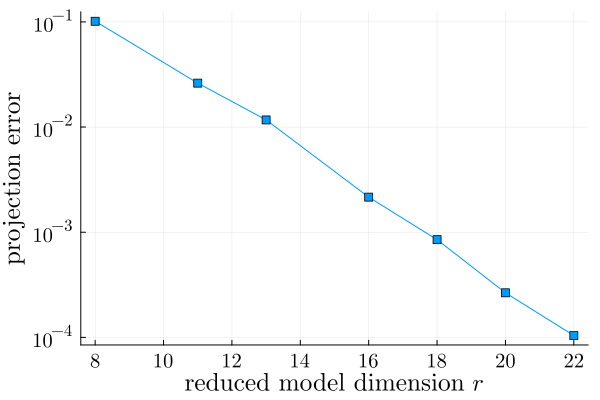

In [24]:
# Training data
mean_train_proj_err = mean(RES["train_proj_err"], dims=2)
plot(DATA["ro"], mean_train_proj_err, marker=(:rect), fontfamily="Computer Modern")
plot!(yscale=:log10, majorgrid=true, legend=false)
yticks!([1e-1, 1e-2, 1e-3, 1e-4])
xticks!([8, 10, 12, 14, 16, 18, 20, 22])
xlabel!("reduced model dimension " * L"r")
ylabel!("projection error")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

### Relative state error

In [25]:
# Least-squares
RES["train_state_err"][:LS] = analyze_rse(OPS["op_LS"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:15

Progress:  43%|██████████████████                       |  ETA: 0:00:13

Progress:  57%|████████████████████████                 |  ETA: 0:00:09

Progress:  71%|██████████████████████████████           |  ETA: 0:00:06

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21

In [26]:
# Intrusive
RES["train_state_err"][:int] = analyze_rse(OPS["op_int"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:12

Progress:  43%|██████████████████                       |  ETA: 0:00:11

Progress:  57%|████████████████████████                 |  ETA: 0:00:08

Progress:  71%|██████████████████████████████           |  ETA: 0:00:06

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [27]:
# EPHEC
RES["train_state_err"][:ephec] = analyze_rse(OPS["op_ephec"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:12

Progress:  43%|██████████████████                       |  ETA: 0:00:11

Progress:  57%|████████████████████████                 |  ETA: 0:00:08

Progress:  71%|██████████████████████████████           |  ETA: 0:00:06

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [28]:
# EPSIC
RES["train_state_err"][:epsic] = analyze_rse(OPS["op_epsic"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:12

Progress:  43%|██████████████████                       |  ETA: 0:00:11

Progress:  57%|████████████████████████                 |  ETA: 0:00:08

Progress:  71%|██████████████████████████████           |  ETA: 0:00:06

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [29]:
# EPP
RES["train_state_err"][:epp] = analyze_rse(OPS["op_epp"], KSE, DATA["Xtr_all"], DATA["Vr"], DATA["IC_train"], DATA["ro"], DS, KSE.integrate_FD);

Progress:  29%|████████████                             |  ETA: 0:00:12

Progress:  43%|██████████████████                       |  ETA: 0:00:11

Progress:  57%|████████████████████████                 |  ETA: 0:00:08

Progress:  71%|██████████████████████████████           |  ETA: 0:00:06

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


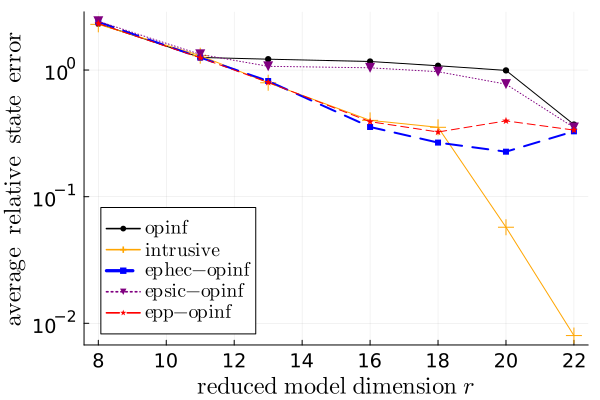

In [30]:
mean_LS_state_err = mean(RES["train_state_err"][:LS], dims=2)
mean_int_state_err = mean(RES["train_state_err"][:int], dims=2)
mean_ephec_state_err = mean(RES["train_state_err"][:ephec], dims=2)
mean_epsic_state_err = mean(RES["train_state_err"][:epsic], dims=2)
mean_epp_state_err = mean(RES["train_state_err"][:epp], dims=2)

plot(DATA["ro"], mean_LS_state_err, c=:black, marker=(:circle, 3.5, :black), label=L"\mathrm{opinf}")
plot!(DATA["ro"], mean_int_state_err, c=:orange, marker=(:cross, 8, :orange), label=L"\mathrm{intrusive}")
plot!(DATA["ro"], mean_ephec_state_err, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(DATA["ro"], mean_epsic_state_err, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(DATA["ro"], mean_epp_state_err, c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
yticks!([1e-0, 1e-1, 1e-2, 1e-3])
xticks!([8, 10, 12, 14, 16, 18, 20, 22])
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{average~~relative~~state~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)


### Constraint Residual

In [31]:
# Least-squares
RES["train_CR"][:LS] = analyze_cr(OPS["op_LS"], "F", KSE, DATA["IC_train"], DATA["ro"])
# Intrusive
RES["train_CR"][:int] = analyze_cr(OPS["op_int"], "F", KSE, DATA["IC_train"], DATA["ro"])
# EPHEC
RES["train_CR"][:ephec] = analyze_cr(OPS["op_ephec"], "F", KSE, DATA["IC_train"], DATA["ro"])
# EPSIC
RES["train_CR"][:epsic] = analyze_cr(OPS["op_epsic"], "F", KSE, DATA["IC_train"], DATA["ro"])
# EPP
RES["train_CR"][:epp] = analyze_cr(OPS["op_epp"], "F", KSE, DATA["IC_train"], DATA["ro"]);

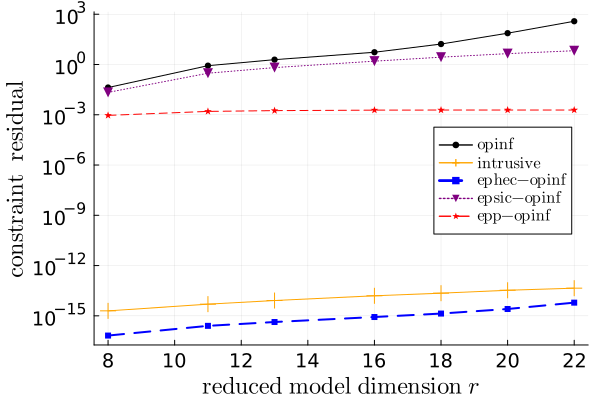

In [32]:
mean_LS_CR_tr = mean(RES["train_CR"][:LS], dims=2)
mean_int_CR_tr = mean(RES["train_CR"][:int], dims=2)
mean_ephec_CR_tr = mean(RES["train_CR"][:ephec], dims=2)
mean_epsic_CR_tr = mean(RES["train_CR"][:epsic], dims=2)
mean_epp_CR_tr = mean(RES["train_CR"][:epp], dims=2)

plot(DATA["ro"], mean_LS_CR_tr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(DATA["ro"], mean_int_CR_tr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(DATA["ro"], mean_ephec_CR_tr, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(DATA["ro"], mean_epsic_CR_tr, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(DATA["ro"], mean_epp_CR_tr, c=:red, markerstrokecolor=:red, marker=(:star, 4), ls=:dash, lw=1, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:right, minorgridalpha=0.03)
yticks!(10.0 .^ [-15, -12, -9, -6, -3, 0, 3])
xticks!([8, 10, 12, 14, 16, 18, 20, 22])
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=11)

### Autocorrelation

In [34]:
# For all initial conditions
# function analyze_autocorr(op::LnL.operators, model::Abstract_Models, Vr_all::AbstractArray{AbstractMatrix},
#         IC::AbstractArray{AbstractArray}, ro::AbstractVector, integrator::Function, lags::AbstractArray)

#     num_ic_params = length(IC)
#     # auto_correletion
#     auto_correlation = Array{Array{Float64}}(undef, length(ro), model.Pdim)
#     ac = Array{Array{Float64}}(undef, num_ic_params)

#     prog = Progress(length(model.μs))
#     for i in eachindex(model.μs)
#         Threads.@threads for (j,r) in collect(enumerate(ro))
#             Vr = Vr_all[i][:, 1:r]
#             for (ct, ic) in enumerate(IC)
#                 Fextract = LnL.extractF(op[i].F, r)
#                 X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * ic)
#                 Xrecon = Vr * X
#                 ac[ct] = tmean_autocorr(Xrecon, lags)
#             end
#             auto_correlation[j, i] = mean(ac)
#         end
#     end
#     return auto_correlation
# end


# For one initial condition
function analyze_autocorr(op, model, Vr_all, IC, ro, integrator, lags)

    # auto_correletion
    auto_correlation = Array{Array{Float64}}(undef, length(ro), model.Pdim)

    for i in eachindex(model.μs)
        prog = Progress(length(ro))
        Threads.@threads for (j,r) in collect(enumerate(ro))
            Vr = Vr_all[i][:, 1:r]

            Fextract = LnL.extractF(op[i].F, r)
            X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * IC)
            Xrecon = Vr * X
            auto_correlation[j, i] = tmean_autocorr(Xrecon, lags)
            next!(prog)
        end
    end
    return auto_correlation
end


# For all initial conditions for full-order model
# function analyze_autocorr(model::Abstract_Models, X_all::AbstractArray, IC::AbstractArray{AbstractArray}, lags::AbstractArray)
#     num_ic_params = length(IC)
#     # auto_correletion
#     auto_correlation = Array{Array{Float64}}(undef, model.Pdim, num_ic_params)
#     ac = Array{Array{Float64}}(undef, num_ic_params)

#     @showprogress for i in eachindex(model.μs)
#         for (ct, ic) in enumerate(IC)
#             auto_correlation[i,ct] = tmean_autocorr(X_all[i,ct], lags)
#         end
#     end
#     return auto_correlation
# end


# For one initial condition for full-order model
function analyze_autocorr(model::Abstract_Models, X_all::AbstractArray, IC_idx::Int64, lags::AbstractArray)
    # auto_correletion
    auto_correlation = Array{Array{Float64}}(undef, model.Pdim)

    prog = Progress(length(model.μs))
    Threads.@threads for i in eachindex(model.μs)
        auto_correlation[i] = tmean_autocorr(X_all[i,IC_idx], lags)
        next!(prog)
    end
    return auto_correlation
end


function tmean_autocorr(X::AbstractArray, lags::AbstractVector)
    N, K = size(X)
    M = length(lags)
    Cx = zeros((N, M))
    
    for i in 1:N  # normalzied autocorrelation
        Cx[i,:] = autocor(X[i,:], lags)
    end
    return vec(mean(Cx, dims=1))
end


# Compute the relative error of the autocorrelation for each reduced dimensions
function autocorr_rel_err(AC, AC_fom)
    rdim, pdim = size(AC)
    AC_rel_err = Array{Float64}(undef, rdim)
    for i in 1:rdim
        err = 0
        for j in 1:pdim
            err += norm(AC[i,j] - AC_fom[j], 2) / norm(AC_fom[j], 2)
        end
        AC_rel_err[i] = err / pdim
    end
    return AC_rel_err
end
;

In [35]:
lags = 0:KSE_data.DS:Int(floor(KSE.Tdim));

In [36]:
# FOM
RES["train_AC"][:fom] = analyze_autocorr(KSE, DATA["Xtr_all"], 1, lags);

In [37]:
# Least-squares
RES["train_AC"][:LS] = analyze_autocorr(OPS["op_LS"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

Progress:  29%|████████████                             |  ETA: 0:04:48

Progress:  43%|██████████████████                       |  ETA: 0:02:34

Progress:  57%|████████████████████████                 |  ETA: 0:01:27

Progress:  71%|██████████████████████████████           |  ETA: 0:00:47

Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


In [38]:
# Intrusive
RES["train_AC"][:int] = analyze_autocorr(OPS["op_int"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

Progress:  43%|██████████████████                       |  ETA: 0:02:36

Progress:  57%|████████████████████████                 |  ETA: 0:01:29

Progress:  71%|██████████████████████████████           |  ETA: 0:00:48

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:20

Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


In [39]:
# EPHEC
RES["train_AC"][:ephec] = analyze_autocorr(OPS["op_ephec"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

Progress:  29%|████████████                             |  ETA: 0:04:59

Progress:  43%|██████████████████                       |  ETA: 0:02:43

Progress:  57%|████████████████████████                 |  ETA: 0:01:33

Progress:  71%|██████████████████████████████           |  ETA: 0:00:50

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:21

Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


In [40]:
# EPSIC
RES["train_AC"][:epsic] = analyze_autocorr(OPS["op_epsic"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

Progress:  29%|████████████                             |  ETA: 0:05:03

Progress:  43%|██████████████████                       |  ETA: 0:02:45

Progress:  57%|████████████████████████                 |  ETA: 0:01:34

Progress:  71%|██████████████████████████████           |  ETA: 0:00:50

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:21

Progress: 100%|█████████████████████████████████████████| Time: 0:02:06


In [41]:
# EPP
RES["train_AC"][:epp] = analyze_autocorr(OPS["op_epp"], KSE, DATA["Vr"], DATA["IC_train"][1], DATA["ro"], KSE.integrate_FD, lags);

Progress:  29%|████████████                             |  ETA: 0:05:00

Progress:  43%|██████████████████                       |  ETA: 0:02:49

Progress:  57%|████████████████████████                 |  ETA: 0:01:35

Progress:  71%|██████████████████████████████           |  ETA: 0:00:51

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:21

Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


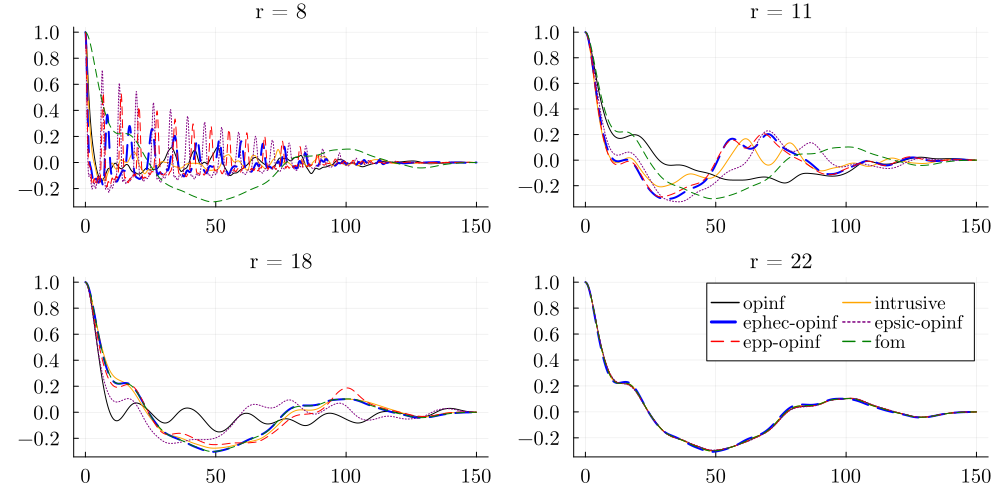

In [107]:
lout = @layout [grid(2,2)]
p = plot(layout=lout, size=(1000, 500))
for (plot_id, ri) in enumerate([1, 2, 5, 7])
    plot!(p[plot_id], lags_t, RES["train_AC"][:LS][ri], c=:black, label="opinf")
    plot!(p[plot_id], lags_t, RES["train_AC"][:int][ri], c=:orange, label="intrusive")
    plot!(p[plot_id], lags_t, RES["train_AC"][:ephec][ri], c=:blue, ls=:dash, lw=2, label="ephec-opinf")
    plot!(p[plot_id], lags_t, RES["train_AC"][:epsic][ri], c=:purple, ls=:dot, label="epsic-opinf")
    plot!(p[plot_id], lags_t, RES["train_AC"][:epp][ri], c=:red, lw=1, ls=:dash, label="epp-opinf")
    plot!(p[plot_id], lags_t, RES["train_AC"][:fom], c=:green, lw=1, ls=:dash, label="fom")
    plot!(p[plot_id], fontfamily="Computer Modern", guidefontsize=12, tickfontsize=13)
    plot!(p[plot_id], title="r = $(DATA["ro"][ri])", titlefontsize=14, titlefontfamily="Computer Modern")
    plot!(bottom_margin=4mm, left_margin=3mm)
    # xlabel!(p[plot_id], "lag")
    # ylabel!(p[plot_id], "normalized autocorrelation")
    yticks!(p[plot_id], [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    if plot_id == 4
        plot!(p[plot_id], legend=:topright, legend_column=2, legendfontsize=12)
    else
        plot!(p[plot_id], legend=false)
    end
end
display(p)

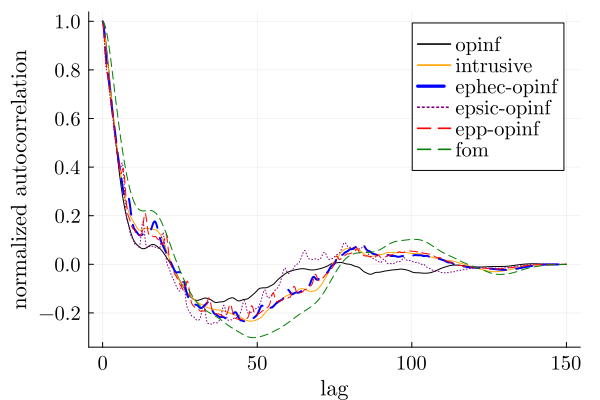

In [79]:
fom_AC = RES["train_AC"][:fom]
mean_LS_AC = mean(RES["train_AC"][:LS])
mean_int_AC = mean(RES["train_AC"][:int])
mean_ephec_AC = mean(RES["train_AC"][:ephec])
mean_epsic_AC = mean(RES["train_AC"][:epsic])
mean_epp_AC = mean(RES["train_AC"][:epp])

lags_t = collect(lags) .* KSE.Δt

# Without markers
plot(lags_t, mean_LS_AC, c=:black, label="opinf")
plot!(lags_t, mean_int_AC, c=:orange, label="intrusive")
plot!(lags_t, mean_ephec_AC, c=:blue, ls=:dash, lw=2, label="ephec-opinf")
plot!(lags_t, mean_epsic_AC, c=:purple, ls=:dot, label="epsic-opinf")
plot!(lags_t, mean_epp_AC, c=:red, lw=1, ls=:dash, label="epp-opinf")
plot!(lags_t, fom_AC, c=:green, lw=1, ls=:dash, label="fom")

plot!(majorgrid=true, legend=:topright)
xlabel!("lag")
ylabel!("normalized autocorrelation")
yticks!([-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plot!(fontfamily="Computer Modern", guidefontsize=14, tickfontsize=13,  legendfontsize=13)
plot!(left_margin=3mm, right_margin=3mm)

In [43]:
LS_AC_over_r = autocorr_rel_err(RES["train_AC"][:LS], RES["train_AC"][:fom])
int_AC_over_r = autocorr_rel_err(RES["train_AC"][:int], RES["train_AC"][:fom])
ephec_AC_over_r = autocorr_rel_err(RES["train_AC"][:ephec], RES["train_AC"][:fom])
epsic_AC_over_r = autocorr_rel_err(RES["train_AC"][:epsic], RES["train_AC"][:fom])
epp_AC_over_r = autocorr_rel_err(RES["train_AC"][:epp], RES["train_AC"][:fom]);

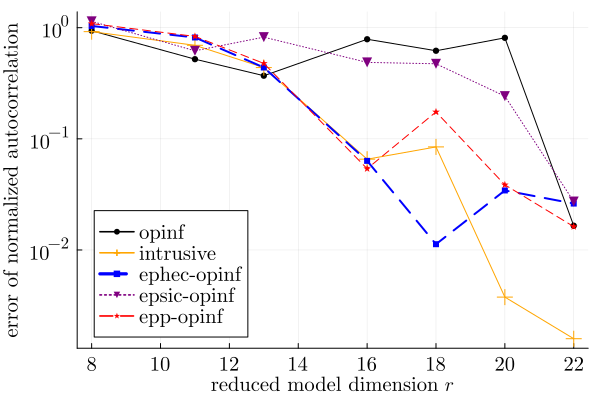

In [47]:
plot(DATA["ro"], LS_AC_over_r, c=:black, marker=(:circle, 3.5, :black), label="opinf")
plot!(DATA["ro"], int_AC_over_r, c=:orange, marker=(:cross, 8, :orange), label="intrusive")
plot!(DATA["ro"], ephec_AC_over_r, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="ephec-opinf")
plot!(DATA["ro"], epsic_AC_over_r, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label="epsic-opinf")
plot!(DATA["ro"], epp_AC_over_r, c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label="epp-opinf")

plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
xlabel!("reduced model dimension " * L" r")
ylabel!("error of normalized autocorrelation")
yticks!([1e-0, 1e-1, 1e-2, 1e-3])
xticks!([8, 10, 12, 14, 16, 18, 20, 22])
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13,  legendfontsize=13)


### Lyapunov Exponent

In [130]:
struct LE_options
    m::Int64         # the number of the most exponents to compute
    τ::Real          # time to simulate the system before computing exponents
    T::Real          # time between reorthogonalization steps
    N::Int64         # the total number of reorthogonalization steps
    ϵ::Real          # perturbation magnitude
    verbose::Bool    # print progress to stdout
end

function lyapunovExponent(
    model::Abstract_Models,  # dynamical model
    ops::LnL.operators,      # operators for the full/reduced model
    integrator::Function,    # integrator for the full/reduced model
    ic::AbstractArray,       # initial condition
    options::LE_options      # options for the algorithm
    )

    # Unpack options
    m = options.m
    τ = options.τ
    T = options.T
    N = options.N
    ϵ = options.ϵ

    nx = size(ic, 1)
    @assert m <= nx "m must be less than or equal to the dimension of the system"
    @assert model.Δt <= T "T must be greater than or equal to the time step size"

    tmp = integrator(ops.A, ops.F, collect(model.T[1]:model.Δt:τ), ic)
    ujm1 = tmp[:, end]
    ujm2 = tmp[:, end-1]

    λ = zeros(m)         # Lyapunov exponents
    Q = 1.0I(nx)[:,1:m]  # orthogonal directions
    # Q = mapslices(x -> x / norm(x), svd(tmp).U[:,1:m], dims=1)  # orthogonal directions with SVD

    if options.verbose
        prog = Progress(N)
    end
    tj = τ
    for j in 1:N
        ujm2_sq = LnL.vech(ujm2 * ujm2')
        uj = integrator(ops.A, ops.F, collect(tj:model.Δt:tj+T), ujm1; u2_lm1=ujm2_sq)[:,end]

        Threads.@threads for i in 1:m
            u_tjm1 = ujm1 + ϵ * Q[:,i]  # perturb the starting value
            wj_i = integrator(ops.A, ops.F, collect(tj:model.Δt:tj+T), u_tjm1; u2_lm1=ujm2_sq)[:,end]
            Q[:,i] = (wj_i - uj) / ϵ
        end
        QR = LinearAlgebra.qr(Q)
        Q = Matrix(QR.Q)  # update the Q matrix
        R = QR.R          # obtain the R matrix (upper triangular: expansion/contraction rates)
        posDiag_QR!(Q, R) # make sure the diagonal of R is positive
        Q = Q[:, 1:m]     # truncate Q to the first m columns
        R = R[1:m, 1:m]   # truncate R to the first m rows and columns

        # add to the Lyapunov exponents
        λ .+= log.(diag(R))

        # update values
        tj += T
        ujm2 = ujm1
        ujm1 = uj

        if options.verbose
            next!(prog)
        end
    end

    return λ / N / T
end

# Dispatch for ROM
function lyapunovExponent(
    model::Abstract_Models,  # dynamical model
    ops::LnL.operators,      # operators for the full/reduced model
    integrator::Function,    # integrator for the full/reduced model
    ic::AbstractArray,       # initial condition
    Vr::AbstractArray,       # basis for the reduced model
    options::LE_options      # options for the algorithm
    )

    # Unpack options
    m = options.m
    τ = options.τ
    T = options.T
    N = options.N
    ϵ = options.ϵ

    nx = size(ic, 1)
    @assert m <= nx "m must be less than or equal to the dimension of the system"
    @assert model.Δt <= T "T must be greater than or equal to the time step size"

    ro = size(Vr, 2)
    if size(ops.A, 1) !== ro
        A = ops.A[1:ro, 1:ro]
        F = LnL.extractF(ops.F, ro)
    else
        A = ops.A
        F = ops.F
    end

    tmp = integrator(A, F, collect(model.T[1]:model.Δt:τ), Vr' * ic)
    ujm1 = tmp[:, end]      # u(j-1): dimension r << nx
    ujm2 = tmp[:, end-1]    # u(j-2): dimension r << nx
    ujm1_recon = Vr * ujm1  # u(j-1): dimension nx (reconstructed states)
    ujm2_recon = Vr * ujm2  # u(j-2): dimension nx (reconstructed states)

    λ = zeros(m)         # Lyapunov exponents
    Q = 1.0I(nx)[:,1:m]  # orthogonal directions

    if options.verbose
        prog = Progress(N)
    end
    tj = τ
    for j in 1:N
        # Run the ROM
        ujm2_sq = LnL.vech(ujm2 * ujm2')
        uj = integrator(A, F, collect(tj:model.Δt:tj+T), ujm1; u2_lm1=ujm2_sq)[:,end]

        # Reconstruct the full order states
        uj_recon = Vr * uj

        Threads.@threads for i in 1:m
            u_tjm1 = ujm1_recon + ϵ * Q[:,i]  # perturb the starting value
            wj_i = integrator(A, F, collect(tj:model.Δt:tj+T), Vr' * u_tjm1; u2_lm1=ujm2_sq)[:,end]
            wj_i_recon = Vr * wj_i  # reconstruct the full order perturbed states
            Q[:,i] = (wj_i_recon - uj_recon) / ϵ
        end
        QR = LinearAlgebra.qr(Q)
        Q = Matrix(QR.Q)  # update the Q matrix
        R = QR.R          # obtain the R matrix (upper triangular: expansion/contraction rates)
        posDiag_QR!(Q, R) # make sure the diagonal of R is positive
        Q = Q[:, 1:m]     # truncate Q to the first m columns
        R = R[1:m, 1:m]   # truncate R to the first m rows and columns

        # add to the Lyapunov exponents
        λ .+= log.(diag(R))

        # update values
        tj += T
        ujm2 = ujm1
        ujm1 = uj
        ujm1_recon = uj_recon

        if options.verbose
            next!(prog)
        end
    end

    return λ / N / T
end


function posDiag_QR!(Q::AbstractMatrix, R::AbstractMatrix)
    @assert size(Q, 2) == size(R, 2) "Q and R must have the same number of columns"

    m = size(Q, 2)
    for i in 1:m
        if R[i,i] < 0
            Q[:,i] = -Q[:,i]
            R[i,:] = -R[i,:]
        end
    end
end
;

In [123]:
# # All initial conditions for ROM
# function analyze_lyapExp(model::Abstract_Models, op::LnL.operators, IC::AbstractArray{AbstractArray}, 
#         Vr::AbstractArray{AbstractMatrix}, ro::AbstractArray, integrator::Function, options::LE_options)

#     num_ic_params = length(IC)
#     # Lypuanov Exponents
#     LE = Array{Array{Float64}}(undef, length(ro), model.Pdim)
#     le = Array{Array{Float64}}(undef, num_ic_params)

#     for i in eachindex(model.μs)
#         for (j,r) in enumerate(ro)
#             for (ct, ic) in enumerate(IC)
#                 le[ct] = lyapunovExponent(model, op[i], integrator, ic, Vr[i], options)
#                 @info "$(ct)-th initial condition completed..."
#             end
#             LE[j, i] = mean(le)
#             @info "Reduced order of $(r) completed..."
#         end
#         @info "Loop $(i) out of $(model.Pdim) completed..."
#     end
# end


# One initial condition for ROM
function analyze_lyapExp(model, op, IC, Vr, ro, integrator, options)
    # Lypuanov Exponents
    LE = Array{Array{Float64}}(undef, length(ro), model.Pdim)

    for i in eachindex(model.μs)
        for (j,r) in enumerate(ro)
            LE[j,i] = lyapunovExponent(model, op[i], integrator, IC, Vr[i][:,1:r], options)
            @info "Reduced order of $(r) completed..."
        end
        @info "Loop $(i) out of $(model.Pdim) completed..."
    end
    return LE
end

# # For all initial conditions for FOM
# function analyze_lyapExp(model::Abstract_Models, op::LnL.operators, IC::AbstractArray{AbstractArray}, 
#         integrator::Function, options::LE_options)

#     num_ic_params = length(IC)
#     # auto_correletion
#     LE = Array{Array{Float64}}(undef, model.Pdim, num_ic_params)
#     le = Array{Array{Float64}}(undef, num_ic_params)

#     for i in eachindex(model.μs)
#         for (ct, ic) in enumerate(IC)
#             LE[i,ct] = lyapunovExponent(model, op[i], integrator, ic, options)
#             @info "$(ct)-th initial condition completed..."
#         end
#         @info "Loop $(i) out of $(model.Pdim) completed..."
#     end
#     return LE
# end

# One initial condition for FOM
function analyze_lyapExp(model, op, IC, integrator, options)
    # auto_correletion
    LE = Array{Array{Float64}}(undef, model.Pdim)

    for i in eachindex(model.μs)
        LE[i] = lyapunovExponent(model, op[i], integrator, IC, options)
        @info "Loop $(i) out of $(model.Pdim) completed..."
    end
    return LE
end
;

In [131]:
le_option = LE_options(10, 1000, 2, 1000, 1e-6, false);

In [ ]:
RES["train_LE"][:fom] = analyze_lyapExp(KSE, DATA["op_fom_tr"], DATA["IC_train"][1], KSE.integrate_FD, le_option)

In [ ]:
RES["train_LE"][:LS] = analyze_lyapExp(KSE, OPS["op_LS"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option);

In [ ]:
RES["train_LE"][:int] = analyze_lyapExp(KSE, OPS["op_int"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option)

In [ ]:
RES["train_LE"][:ephec] = analyze_lyapExp(KSE, OPS["op_ephec"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option)

In [ ]:
RES["train_LE"][:epsic] = analyze_lyapExp(KSE, OPS["op_epsic"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option)

In [ ]:
RES["train_LE"][:epp] = analyze_lyapExp(KSE, OPS["op_epp"], DATA["IC_train"][1], DATA["Vr"], DATA["ro"], KSE.integrate_FD, le_option)

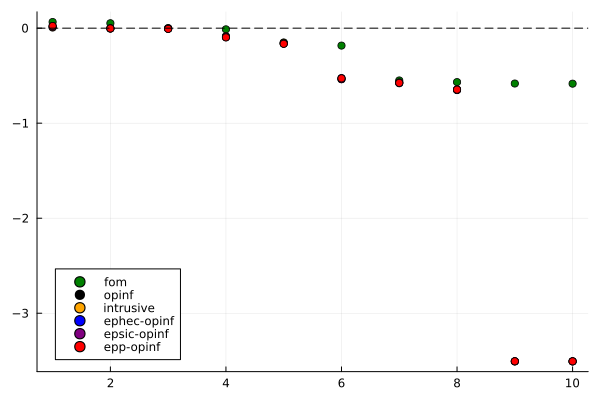

In [161]:
scatter(RES["train_LE"][:fom], c=:green, label="fom")
scatter!(RES["train_LE"][:LS][end], c=:black, label="opinf")
scatter!(RES["train_LE"][:int][end], c=:orange, label="intrusive")
scatter!(RES["train_LE"][:ephec][end], c=:blue, label="ephec-opinf")
scatter!(RES["train_LE"][:epsic][end], c=:purple, label="epsic-opinf")
scatter!(RES["train_LE"][:epp][end], c=:red, label="epp-opinf")
hline!([0.0], c=:black, ls=:dash, label=false)

In [162]:
LE_fom_mean = mean(RES["train_LE"][:fom])
LE_LS_mean = mean(RES["train_LE"][:LS])
LE_int_mean = mean(RES["train_LE"][:int])
LE_ephec_mean = mean(RES["train_LE"][:ephec])
LE_epsic_mean = mean(RES["train_LE"][:epsic])
LE_epp_mean = mean(RES["train_LE"][:epp]);

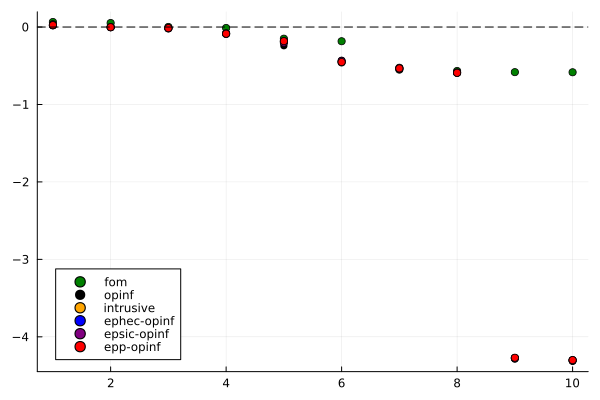

In [163]:
scatter(LE_fom_mean, c=:green, label="fom")
scatter!(LE_LS_mean, c=:black, label="opinf")
scatter!(LE_int_mean, c=:orange, label="intrusive")
scatter!(LE_ephec_mean, c=:blue, label="ephec-opinf")
scatter!(LE_epsic_mean, c=:purple, label="epsic-opinf")
scatter!(LE_epp_mean, c=:red, label="epp-opinf")
hline!([0.0], c=:black, ls=:dash, label=false)

### Kaplan–Yorke/Lyapunov Dimension

In [181]:
function compute_Dky(λs::AbstractArray; sorted::Bool=true)
    if !sorted
        λs = sort(λs, rev=true)
    end

    # Find the index where the sum of λ becomes negative
    j = nothing
    tmp = 0
    for (i,λ) in enumerate(λs)
        tmp += λ
        if tmp < 0
            j = i
            break
        end
    end

    if j == nothing
        return length(λs) + sum(λs)
    elseif j == 1
        return 0
    else
        return (j - 1) + sum(λs[1:j-1]) / abs(λs[j])
    end
end


function analyze_Dky(LEs; sorted=true)
    Dky = Array{Float64}(undef, size(LEs)...)
    for i in CartesianIndices(LEs)
        Dky[i] = compute_Dky(LEs[i], sorted=sorted)
    end
    return Dky
end

analyze_Dky (generic function with 2 methods)

In [182]:
RES["train_DKY"][:fom] = analyze_Dky(RES["train_LE"][:fom])
RES["train_DKY"][:LS] = analyze_Dky(RES["train_LE"][:LS])
RES["train_DKY"][:int] = analyze_Dky(RES["train_LE"][:int])
RES["train_DKY"][:ephec] = analyze_Dky(RES["train_LE"][:ephec])
RES["train_DKY"][:epsic] = analyze_Dky(RES["train_LE"][:epsic])
RES["train_DKY"][:epp] = analyze_Dky(RES["train_LE"][:epp]);

In [197]:
using DataFrames

dky_df = DataFrame(
    # fom=vec(RES["train_DKY"][:fom]),
    order=vec(DATA["ro"]),
    int=vec(RES["train_DKY"][:int]),
    LS=vec(RES["train_DKY"][:LS]),
    ephec=vec(RES["train_DKY"][:ephec]),
    epsic=vec(RES["train_DKY"][:epsic]),
    epp=vec(RES["train_DKY"][:epp])
)
println("FOM Dky:     ", mean(RES["train_DKY"][:fom]))
println("Ref FOM Dky: ", 4.74176471)
dky_df

FOM Dky:     4.702755360032331
Ref FOM Dky: 4.74176471


7×6 DataFrame
 Row │ order  int      LS       ephec    epsic    epp     
     │ Int64  Float64  Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────────────────────
   1 │     8  0.0      0.0      0.0      0.0      0.0
   2 │    11  3.48103  3.44927  2.88419  2.95542  3.45394
   3 │    13  3.26416  3.26125  3.27093  3.27573  3.23312
   4 │    16  3.12542  3.38523  3.13429  3.16028  3.17187
   5 │    18  3.05675  3.67787  3.17276  3.10063  3.02678
   6 │    20  3.14139  3.48392  3.20453  3.16713  3.11683
   7 │    22  2.35537  3.06951  3.14691  3.07005  3.11996

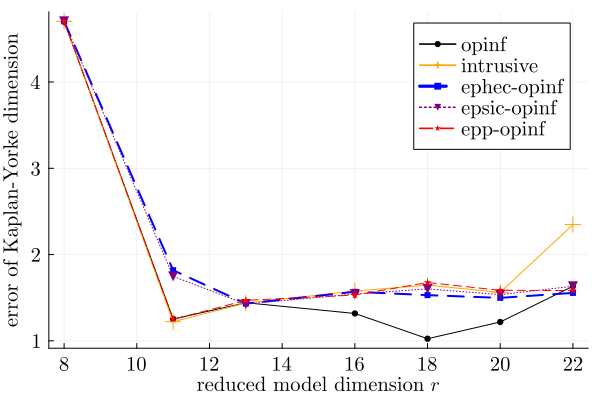

In [204]:
plot(DATA["ro"], abs.(RES["train_DKY"][:LS] .- RES["train_DKY"][:fom]), c=:black, marker=(:circle, 3.5, :black), label="opinf")
plot!(DATA["ro"], abs.(RES["train_DKY"][:int] .- RES["train_DKY"][:fom]), c=:orange, marker=(:cross, 8, :orange), label="intrusive")
plot!(DATA["ro"], abs.(RES["train_DKY"][:ephec] .- RES["train_DKY"][:fom]), c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="ephec-opinf")
plot!(DATA["ro"], abs.(RES["train_DKY"][:epsic] .- RES["train_DKY"][:fom]), c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label="epsic-opinf")
plot!(DATA["ro"], abs.(RES["train_DKY"][:epp] .- RES["train_DKY"][:fom]), c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label="epp-opinf")

plot!(majorgrid=true, legend=:topright)
xlabel!("reduced model dimension " * L" r")
ylabel!("error of Kaplan-Yorke dimension")
xticks!([8, 10, 12, 14, 16, 18, 20, 22])
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13,  legendfontsize=13)


In [194]:
save(resultfile, RES)

### Flow Field Comparison

In [ ]:
i = 6
r = DATA["ro"][end]
ic = DATA["IC_train"][i]
Vr = DATA["Vr"][1][:, 1:r]
X_int = KSE.integrate_FD(OPS["op_int"][1].A[1:r, 1:r], LnL.extractF(OPS["op_int"][1].F, r), KSE.t, Vr' * ic)
X_LS = KSE.integrate_FD(OPS["op_LS"][1].A[1:r, 1:r], LnL.extractF(OPS["op_LS"][1].F, r), KSE.t, Vr' * ic)
X_ephec = KSE.integrate_FD(OPS["op_ephec"][1].A[1:r, 1:r], LnL.extractF(OPS["op_ephec"][1].F, r), KSE.t, Vr' * ic)
X_epsic = KSE.integrate_FD(OPS["op_epsic"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epsic"][1].F, r), KSE.t, Vr' * ic)
X_epp = KSE.integrate_FD(OPS["op_epp"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epp"][1].F, r), KSE.t, Vr' * ic)


# lout = @layout [a{0.3h}; [grid(2,2)]]
lout = @layout [grid(6,2)]
p_fom = plot(contourf(KSE.t[1:DS:end], KSE.x, DATA["Xtr_all"][i][:, 1:DS:end], lw=0,), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
p_int = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_int[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
p_int_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_int[:, 1:DS:end]), lw=0, color=:roma), colorbar_ticks=(0:0.5:5), clim=(0,5), yticks=(0:5:20), ylims=(0,20))
p_LS = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_LS[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
p_LS_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_LS[:, 1:DS:end]), lw=0, color=:roma), colorbar_ticks=(0:0.5:5), clim=(0,5), yticks=(0:5:20), ylims=(0,20))
p_ephec = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_ephec[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
p_ephec_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_ephec[:, 1:DS:end]), lw=0, color=:roma), colorbar_ticks=(0:0.5:5), clim=(0,5), yticks=(0:5:20), ylims=(0,20))
p_epsic = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epsic[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
p_epsic_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epsic[:, 1:DS:end]), lw=0, color=:roma), colorbar_ticks=(0:0.5:5), clim=(0,5), yticks=(0:5:20), ylims=(0,20))
p_epp = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epp[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
p_epp_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epp[:, 1:DS:end]), lw=0, color=:roma), colorbar_ticks=(0:0.5:5), clim=(0,5), yticks=(0:5:20), ylims=(0,20))
pblank = plot(legend=false,grid=false,foreground_color_subplot=:white)

plot(
    p_fom, pblank, 
    p_int, p_int_err,
    p_LS, p_LS_err,
    p_ephec, p_ephec_err,
    p_epsic, p_epsic_err,
    p_epp, p_epp_err, 
    fontfamily="Computer Modern", layout=lout, margins=0mm, size=(1200, 1000)
)